## Семинар 5: "Улучшение сходимости нейросетей"

ФИО: Сербин Георгий Эдуардович

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import torch
from torch import nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision import transforms
%matplotlib inline

## Описание задания:
Вам необходимо реализовать оставшиеся методы из лекции и сравнить их на примере из семинара.

## Задание разделено на следующие части:
1. Реализация Xavier **(1 балл)**

2.1 Реализация DropConnect **(1 балл)**

2.2 Сравнение обучения при использовании Dropout и DropConnect **(1 балл)**

3.1 Реализация LayerNorm **(1 балл)**

3.2 Сравнение обучения при использовании BatchNorm и LayerNorm **(1 балл)**

## Срок выполнения задания:
Данное задание можно сдать без штрафов до 16 октября.


### Часть 1: Инициализация весов

Будем использовать MNIST для обучения:

In [ ]:
# Dataloader
to_numpy = lambda x: x.numpy()
transform = transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                    ])
train_dataset = MNIST('.', train=True, download=True, transform=transform)
test_dataset = MNIST('.', train=False, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=True)

100%|██████████| 9912422/9912422 [00:00<00:00, 108305054.87it/s]


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 83657247.12it/s]


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 44479762.53it/s]

Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 15071620.86it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



In [ ]:
images_train, labels_train = next(iter(train_loader))

In [ ]:
## Usage example:
for X, y in train_loader:
    X = X.view(X.size(0), -1)
    X = X.numpy() ### Converts torch.Tensor to numpy array
    y = y.numpy()
    break

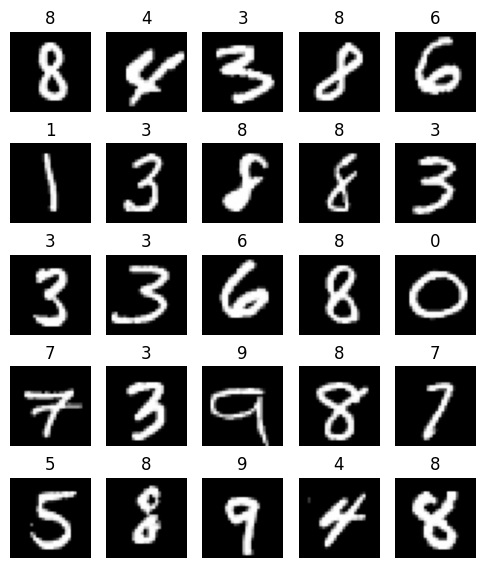

In [ ]:
plt.figure(figsize=(6, 7))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(X[i].reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.title(y[i])
    plt.axis('off')

In [ ]:
def init_layer(layer, mean=0, std=1):
    # Тут надо быть аккуратным — можно случайно создать копию и менять значения у копии
    weight = layer.state_dict()['weight']
    bias = layer.state_dict()['bias']
    bias.zero_()
    weight.normal_(mean=0, std=std)

def forward_hook(self, input_, output):
    std = input_[0].std().item()
    print('forward', std)

def backward_hook(self, grad_input, grad_output):
    std = grad_input[0].std().item()
    print('backward', std)

На вход передаем изображение 28x28, на выходе -- вероятности 10 классов.

In [ ]:
layer_1 = nn.Linear(28*28, 500)
layer_2 = nn.Linear(500, 10)

layer_1.register_forward_hook(forward_hook)
layer_2.register_forward_hook(forward_hook)

layer_1.register_backward_hook(backward_hook)
layer_2.register_backward_hook(backward_hook)

init_layer(layer_1)
init_layer(layer_2)

Соберем все вместе, используя ReLU в качестве функции активации:

In [ ]:
network = nn.Sequential(
    layer_1,
    nn.ReLU(),
    layer_2
)

#### 1.1 Реализуйте инициализацию Xavier. Сравните ее с He, которая была реализована на семинаре, сделайте выводы. Учтите, что для Xavier необходимо использовать функцию активации nn.Tanh(). **(1 балл)**

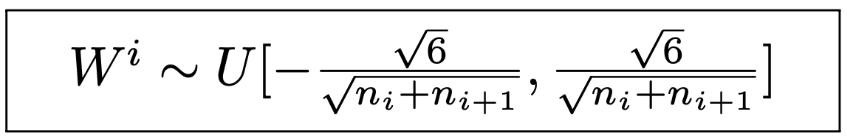

In [ ]:
##### YOUR CODE HERE #####
from math import sqrt

def xavier_init_layer(layer, r1, r2):
    # Тут надо быть аккуратным — можно случайно создать копию и менять значения у копии
    weight = layer.state_dict()['weight']
    bias = layer.state_dict()['bias']
    bias.zero_()
    weight.uniform_(r1, r2)


layer_1 = nn.Linear(28*28, 500)
layer_2 = nn.Linear(500, 10)

layer_1.register_forward_hook(forward_hook)
layer_2.register_forward_hook(forward_hook)

layer_1.register_backward_hook(backward_hook)
layer_2.register_backward_hook(backward_hook)

init_layer(layer_1, -sqrt(6)/sqrt(28*28+500), sqrt(6)/sqrt(28*28+500))
init_layer(layer_2, -sqrt(6)/sqrt(500+10), sqrt(6)/sqrt(500+10))

In [ ]:
network = nn.Sequential(
    layer_1,
    nn.Tanh(),
    layer_2
)

n_objects = 100
X = images_train[:n_objects].view(n_objects, -1).data
y = labels_train[:n_objects].data
activations = network(X)
loss_fn = torch.nn.NLLLoss()
optimizer = torch.optim.Adam(network.parameters(), lr=0.001)
loss = loss_fn(activations, y)
loss.backward()

forward 1.0024043321609497
forward 0.787933349609375
backward 0.03162277489900589
backward 0.014368182048201561


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


Стандартные отклонения выходов слоев оказались близки к единичным, что и предполагалось в теории данной инициализации весов.

## Часть 2: DropConnect

#### 2.1 Реализуйте DropConnect по следующему шаблону: **(1 балл)**

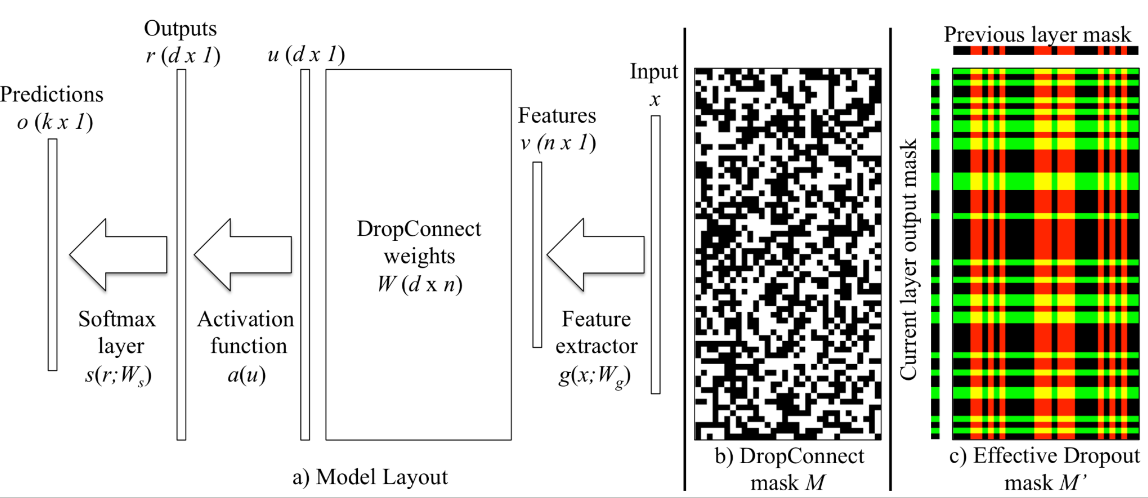

In [ ]:
# полезная функция: .bernoulli_(p)
# не забывайте делать requires_grad=False у маски
# помните, что в вычислениях должны участвовать Variable, а не тензоры

class DropConnect(nn.Module):
    def __init__(self, in_features, out_features, bias=True, p=0.5):
        super(DropConnect, self).__init__()
        self.p = p
        self.in_features = in_features
        self.out_features = out_features
        self.weight = nn.Parameter(torch.Tensor(out_features, in_features))
        if bias:
            self.bias = nn.Parameter(torch.Tensor(out_features))
        else:
            self.register_parameter('bias', None)
        init_layer(self, -sqrt(6)/sqrt(in_features+out_features+1), sqrt(6)/sqrt(in_features+out_features+1))

    def forward(self, x):
        mask = torch.empty_like(self.weight).bernoulli_(p=self.p).type(torch.FloatTensor)
        if self.training:
            mask = torch.where(mask > self.p, 1, 0)
        else:
            mask = torch.ones_like(mask) * (1 - self.p)
        mask.detach_()
        output = nn.functional.linear(x, self.weight * mask, self.bias)
        return output

Основа для сети, которую будем обучать:

In [ ]:
class TestNetwork(nn.Module):
    def __init__(self, final_part):
        super().__init__()

        channels = 1

        self.conv_layers = nn.Sequential(
            nn.Conv2d(channels, 2, 3, padding=1),
            nn.MaxPool2d(2),
            nn.ReLU(),
            nn.Conv2d(2, 4, 3, padding=1),
            nn.MaxPool2d(2),
            nn.ReLU(),
        )

        #input_size = 7 * 7 * 4 = 196
        self.flatten = nn.Flatten()

        self.final_part = final_part

        self.log_softmax = nn.LogSoftmax(1)

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.flatten(x)
        x = self.final_part(x)
        return self.log_softmax(x)

Добавим несколько слоев в конец сети:

In [ ]:
layers = [
    nn.Linear(196,128),
    nn.ReLU(),
    DropConnect(128,128),
    nn.Linear(128,128),
    nn.ReLU(),
    DropConnect(128,128),
    nn.Linear(128,10)
]

In [ ]:
network = TestNetwork(nn.Sequential(*layers))
optimizer = torch.optim.Adam(network.parameters(), lr=0.001)
loss_fn = torch.nn.NLLLoss()

Обучим получившуюся сеть:

In [ ]:
for epoch in range(4):
    network.train()
    for batch_idx, (images_train, labels_train) in enumerate(train_loader):
        optimizer.zero_grad()
        X = images_train.data
        y = labels_train.data
        output = network(X)
        loss = loss_fn(output, y)
        loss.backward()
        optimizer.step()

        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
            epoch, batch_idx * len(X), len(train_loader.dataset),
            100. * batch_idx / len(train_loader), loss.item()))

    network.eval()
    losses = []
    for batch_idx, (images_test, labels_test) in enumerate(test_loader):
        X = images_test.data
        y = labels_test.data
        output = network(X)
        loss = loss_fn(output, y)

        losses.append(loss.item())

    print('Test Epoch: {}\tLoss: {:.6f}'.format(
            epoch, np.mean(losses)))


Train Epoch: 0 [0/60000 (0%)]	Loss: 2.297117
Train Epoch: 0 [12800/60000 (21%)]	Loss: 0.979990
Train Epoch: 0 [25600/60000 (43%)]	Loss: 0.609838
Train Epoch: 0 [38400/60000 (64%)]	Loss: 0.402523
Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.349212
Test Epoch: 0	Loss: 0.301744
Train Epoch: 1 [0/60000 (0%)]	Loss: 0.164170
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.230903
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.255395
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.214202
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.182668
Test Epoch: 1	Loss: 0.205249
Train Epoch: 2 [0/60000 (0%)]	Loss: 0.256815
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.152963
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.134441
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.155938
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.086105
Test Epoch: 2	Loss: 0.145590
Train Epoch: 3 [0/60000 (0%)]	Loss: 0.044851
Train Epoch: 3 [12800/60000 (21%)]	Loss: 0.075466
Train Epoch: 3 [25600/60000 (43%)]	Loss: 0.096480
Train Epoch: 3 [38400/60000 (64%)


#### 2.2 Сравните графики обучения нейроных сетей **(1 балл)**:
1. Свертки из TestNetwork -> 128 -> 128 -> 10 с ReLU и Dropout между всеми слоями
2. Свертки из TestNetwork -> 128 -> 128 -> 10 с ReLU и DropConnect вместо всех линейных слоев


In [ ]:
class Dropout(nn.Module):
    def __init__(self, p=0.5):
        super(Dropout, self).__init__()
        self.p = p

    def forward(self, x):
        mask = torch.empty(x.shape).uniform_(0, 1).type(torch.FloatTensor)
        if self.training:
            mask = torch.where(mask > self.p, 1, 0)
        else:
            mask = torch.where(mask > self.p, 1, 1 - self.p)

        return x * mask

In [ ]:
def train(network):
    train_loss = []
    test_loss_epochs = []
    for epoch in range(4):
        network.train()
        for batch_idx, (images_train, labels_train) in enumerate(train_loader):
            optimizer.zero_grad()
            X = images_train.data
            y = labels_train.data
            output = network(X)
            loss = loss_fn(output, y)
            loss.backward()
            optimizer.step()

            if batch_idx % 100 == 0:
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(X), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
                train_loss.append(loss.item())

        network.eval()
        losses = []
        for batch_idx, (images_test, labels_test) in enumerate(test_loader):
            X = images_test.data
            y = labels_test.data
            output = network(X)
            loss = loss_fn(output, y)

            losses.append(loss.item())

        print('Test Epoch: {}\tLoss: {:.6f}'.format(
                epoch, np.mean(losses)))
        test_loss_epochs.append(np.mean(losses))
    return train_loss, test_loss_epochs


1. Dropout

In [ ]:
layers = [
    nn.Linear(196,128),
    nn.ReLU(),
    Dropout(),
    nn.Linear(128,128),
    nn.ReLU(),
    Dropout(),
    nn.Linear(128,10)
]

network = TestNetwork(nn.Sequential(*layers))
optimizer = torch.optim.Adam(network.parameters(), lr=0.001)
loss_fn = torch.nn.NLLLoss()

train_loss_1, test_loss_epochs_1 = train(network)

Train Epoch: 0 [0/60000 (0%)]	Loss: 2.305027
Train Epoch: 0 [12800/60000 (21%)]	Loss: 1.128265
Train Epoch: 0 [25600/60000 (43%)]	Loss: 0.804305
Train Epoch: 0 [38400/60000 (64%)]	Loss: 0.586359
Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.348010
Test Epoch: 0	Loss: 0.320027
Train Epoch: 1 [0/60000 (0%)]	Loss: 0.289717
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.493699
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.285212
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.323380
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.300991
Test Epoch: 1	Loss: 0.204378
Train Epoch: 2 [0/60000 (0%)]	Loss: 0.216591
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.291954
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.196896
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.178008
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.182654
Test Epoch: 2	Loss: 0.177680
Train Epoch: 3 [0/60000 (0%)]	Loss: 0.185428
Train Epoch: 3 [12800/60000 (21%)]	Loss: 0.242542
Train Epoch: 3 [25600/60000 (43%)]	Loss: 0.431613
Train Epoch: 3 [38400/60000 (64%)

2. Dropconnect

In [ ]:
layers = [
    DropConnect(196,128),
    nn.ReLU(),
    DropConnect(128,128),
    nn.ReLU(),
    nn.Linear(128,10)
]

network = TestNetwork(nn.Sequential(*layers))
optimizer = torch.optim.Adam(network.parameters(), lr=0.001)
loss_fn = torch.nn.NLLLoss()

train_loss_2, test_loss_epochs_2 = train(network)

Train Epoch: 0 [0/60000 (0%)]	Loss: 2.306752
Train Epoch: 0 [12800/60000 (21%)]	Loss: 1.429164
Train Epoch: 0 [25600/60000 (43%)]	Loss: 0.723632
Train Epoch: 0 [38400/60000 (64%)]	Loss: 0.482120
Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.596693
Test Epoch: 0	Loss: 0.283417
Train Epoch: 1 [0/60000 (0%)]	Loss: 0.474735
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.526002
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.522121
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.500061
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.288307
Test Epoch: 1	Loss: 0.203320
Train Epoch: 2 [0/60000 (0%)]	Loss: 0.335135
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.602953
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.360389
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.465944
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.310705
Test Epoch: 2	Loss: 0.162258
Train Epoch: 3 [0/60000 (0%)]	Loss: 0.193134
Train Epoch: 3 [12800/60000 (21%)]	Loss: 0.342330
Train Epoch: 3 [25600/60000 (43%)]	Loss: 0.315063
Train Epoch: 3 [38400/60000 (64%)

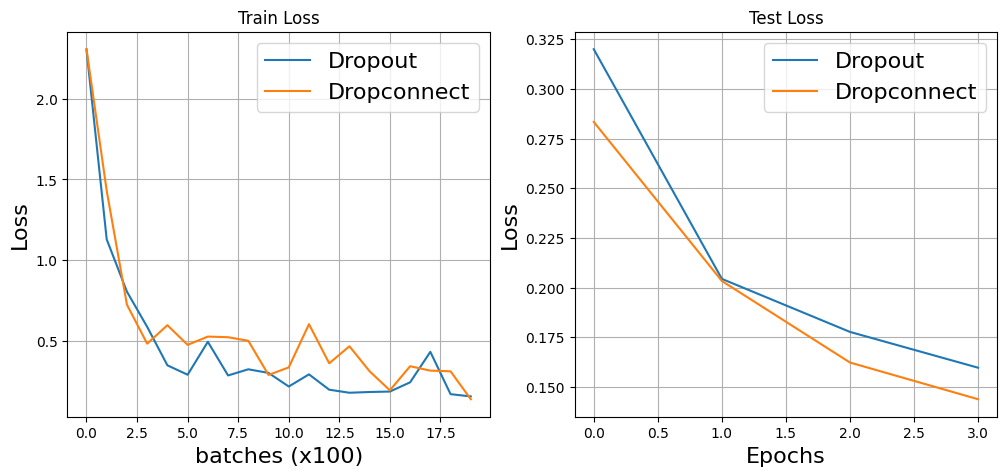

In [ ]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.title('Train Loss')
plt.plot(train_loss_1, label='Dropout')
plt.plot(train_loss_2, label='Dropconnect')
plt.xlabel('batches (x100)', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.legend(loc=0, fontsize=16)
plt.grid()

plt.subplot(1, 2, 2)
plt.title('Test Loss')
plt.plot(test_loss_epochs_1, label='Dropout')
plt.plot(test_loss_epochs_2, label='Dropconnect')
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.legend(loc=0, fontsize=16)
plt.grid()

plt.show()

В целом результаты оказались примерно одинаковыми. Переобучения не обнаружено

### Часть 3: Batch Normalization

Наконец, давайте рассмотрим Batch Normalization. Этот слой вычитает среднее и делит на стандартное отклонение. Среднее и дисперсия вычисляются по батчу независимо для каждого нейрона. У этого слоя есть две важные проблемы: его нельзя использовать при обучении с размером батча 1 и он делает элементы батча зависимыми. Давайте реализуем аналог батч нормализации: <a href=https://arxiv.org/pdf/1607.06450.pdf>Layer normalization</a>. В layer normalization среднее и дисперсия вычисляются по активациям нейронов, независимо для каждого объекта.

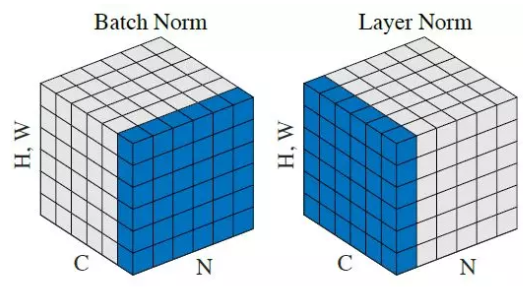

#### 3.1 Реализуйте Layer Normalization **(1 балл)**

In [ ]:
# полезные функции: .std(dim), .mean(dim)

class LayerNormalization(nn.Module):
    def __init__(self, num_features, eps=1e-6):
        super(LayerNormalization, self).__init__()
        self.gamma = nn.Parameter(torch.ones(num_features))
        self.beta = nn.Parameter(torch.zeros(num_features))
        self.eps = eps
    def forward(self, x):
        mean = x.mean(dim=-1, keepdim=True)
        std = x.std(dim=-1, keepdim=True)
        output = (x - mean) / (std + self.eps)
        output = self.gamma * output + self.beta
        return output

#### 3.2 Сравните графики обучения нейроных сетей **(1 балл)**:
1. Свертки из TestNetwork -> 128 -> 128 -> 10 с ReLU и Batch normalization между всеми слоями
2. Свертки из TestNetwork -> 128 -> 128 -> 10 с ReLU и Layer normalization между всеми слоями

In [ ]:
layers = [
    nn.Linear(196,128),
    nn.BatchNorm1d(128),
    nn.ReLU(),
    nn.Linear(128,128),
    nn.BatchNorm1d(128),
    nn.ReLU(),
    nn.Linear(128,10)
]

network = TestNetwork(nn.Sequential(*layers))
optimizer = torch.optim.Adam(network.parameters(), lr=0.001)
loss_fn = torch.nn.NLLLoss()

train_loss_1, test_loss_epochs_1 = train(network)

Train Epoch: 0 [0/60000 (0%)]	Loss: 2.473264
Train Epoch: 0 [12800/60000 (21%)]	Loss: 0.331265
Train Epoch: 0 [25600/60000 (43%)]	Loss: 0.126732
Train Epoch: 0 [38400/60000 (64%)]	Loss: 0.172103
Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.171361
Test Epoch: 0	Loss: 0.096698
Train Epoch: 1 [0/60000 (0%)]	Loss: 0.039976
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.047517
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.071790
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.139394
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.039085
Test Epoch: 1	Loss: 0.075597
Train Epoch: 2 [0/60000 (0%)]	Loss: 0.071735
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.050391
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.056722
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.052545
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.064279
Test Epoch: 2	Loss: 0.075521
Train Epoch: 3 [0/60000 (0%)]	Loss: 0.026685
Train Epoch: 3 [12800/60000 (21%)]	Loss: 0.033752
Train Epoch: 3 [25600/60000 (43%)]	Loss: 0.067976
Train Epoch: 3 [38400/60000 (64%)

In [ ]:
layers = [
    nn.Linear(196,128),
    LayerNormalization(128),
    nn.ReLU(),
    nn.Linear(128,128),
    LayerNormalization(128),
    nn.ReLU(),
    nn.Linear(128,10)
]

network = TestNetwork(nn.Sequential(*layers))
optimizer = torch.optim.Adam(network.parameters(), lr=0.001)
loss_fn = torch.nn.NLLLoss()

train_loss_2, test_loss_epochs_2 = train(network)

Train Epoch: 0 [0/60000 (0%)]	Loss: 2.342747
Train Epoch: 0 [12800/60000 (21%)]	Loss: 0.434333
Train Epoch: 0 [25600/60000 (43%)]	Loss: 0.226876
Train Epoch: 0 [38400/60000 (64%)]	Loss: 0.186138
Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.102754
Test Epoch: 0	Loss: 0.112946
Train Epoch: 1 [0/60000 (0%)]	Loss: 0.053150
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.139891
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.185687
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.111852
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.128434
Test Epoch: 1	Loss: 0.099632
Train Epoch: 2 [0/60000 (0%)]	Loss: 0.062643
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.097925
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.027219
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.059924
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.041139
Test Epoch: 2	Loss: 0.082656
Train Epoch: 3 [0/60000 (0%)]	Loss: 0.041196
Train Epoch: 3 [12800/60000 (21%)]	Loss: 0.023303
Train Epoch: 3 [25600/60000 (43%)]	Loss: 0.102938
Train Epoch: 3 [38400/60000 (64%)

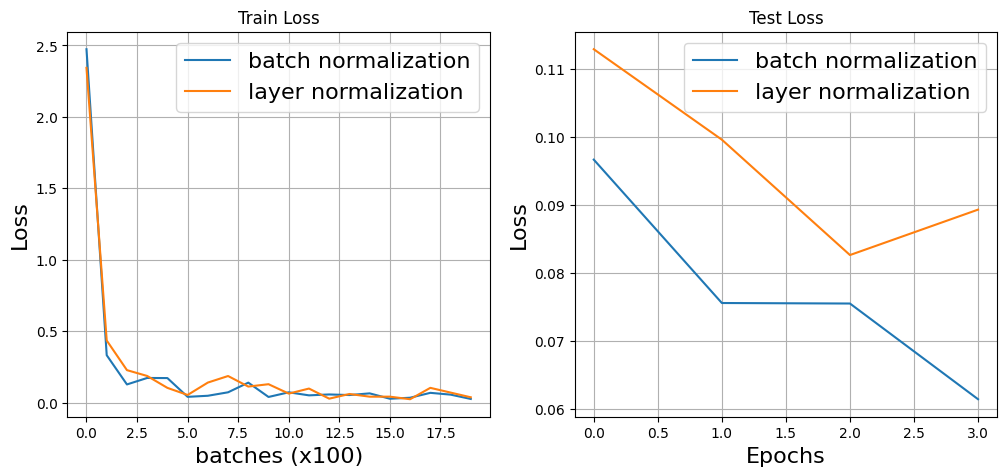

In [ ]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.title('Train Loss')
plt.plot(train_loss_1, label='batch normalization')
plt.plot(train_loss_2, label='layer normalization')
plt.xlabel('batches (x100)', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.legend(loc=0, fontsize=16)
plt.grid()

plt.subplot(1, 2, 2)
plt.title('Test Loss')
plt.plot(test_loss_epochs_1, label='batch normalization')
plt.plot(test_loss_epochs_2, label='layer normalization')
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.legend(loc=0, fontsize=16)
plt.grid()

plt.show()

Batch normalization на тесте показал себя лучше. Возможно за счет того, что на валидации информация о распределении входных данных и выходов внутренних слоев накапливается с помощью экспоненциального среднего, и, таким образом, подстраивается под незнакомые данные.